<a href="https://colab.research.google.com/github/larajakl/Machine-Learning/blob/main/04_LM_LDA_Topic_modeling_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Documents

In this notebook, you'll learn about **Latent Dirichlet Allocation** (LDA) algorithm, and how to use it to cluster documents based on automatically generated topics, made out of their content words.

Key-learning:
- Unsupervised machine learning for NLP
- Clustering Documents
- LDA
- python packages: *pandas*, [*gensim*](https://pypi.org/project/gensim/)

Terms in this notebook:
- Bag of Words (BoW)
- LDA
- Clustering
- TF/IDF

This notebook includes two recommended videos (total length: 25min).

Estimated reading duration: 1-2h.


# Setup

We start by importing [pandas](https://pandas.pydata.org/) - an essential tool for data scientists!

We load a .CSV (Comma Seperated Values) file of German news articles from https://github.com/tblock/10kGNAD


In [1]:
from IPython.display import YouTubeVideo

In [2]:
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

Pandas is a useful package to load CSV files and to parse them. It can also parse TSV - separated by tabs, or as in our case, separated by a `;`.  
Pandas is often used as the first-step for data scientists to load and analyze data.

In [3]:
df_articles = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv',
                 sep=';',       # this file is actually a TSV, separated by ";"
                 on_bad_lines='skip',
                 header=None,   # There is no header line for this CSV...
                 # .. so we define the column names here:
                 names=['article_category', 'content'],
                 # And by specifiying the column as a Categorical type,
                 # we can save computer memory! Yay!
                 dtype={'article_category': 'category'})

**Note:** Specifying a column with repeated strings as a category is a good Pandas' trick to be aware of. Often the dataset can't fit into the memory, and by specifiying columns as a categorical column when loading the data (`pd.read_csv`), we get to spare memory and allow the dataset to fit the working memory better.

In [4]:
df_articles

,article_category,content
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,Mitarbeiter überreichten Eigentümervertretern ...
3,Etat,Service: Jobwechsel in der Kommunikationsbranc...
4,Etat,Was Sie über diese Woche wissen sollten - und ...
...,...,...
9571,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
9572,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
9573,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
9574,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


Our corpus contains 9 categories, as seen below.  
However, our plan now is to **ignore them**, and instead, use an **un**supervised algorithm to deduct the topics only by the articles content.   
Or in other words: we will *cluster* those documents based on their content.

In [ ]:
df_articles['article_category'].cat.categories

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web',
       'Wirtschaft', 'Wissenschaft'],
      dtype='object')

# Clustering with Latent Dirichlet Allocation (LDA)

## Introduction

We start by clustering our data as an unsupervised learning task: **topic modeling**.

There are many different methods to cluster documents. One of these methods is *topic modeling* - where an algorithm assigns a *topic* to each document and clusters these documents by these topics.

Documents can be represented as a distribution of their words: their occurrences and frequencies. A set of words, which are relatively not frequent but are common to several documents, can express a document topic.  
For example, suppose we locate documents with the words 'Android', 'OnePlus' and 'iPhone' in them. Based on the frequency of these words, we could assume that these documents are related to mobile phones.

[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a distribution on probability distributions. In other words, it can handle the frequency of which a set of words appear (which have by themselves, each one, a frequency).

For a deeper mathematical explanation of this distribution, watch this recommended video: https://www.youtube.com/watch?v=nfBNOWv1pgE

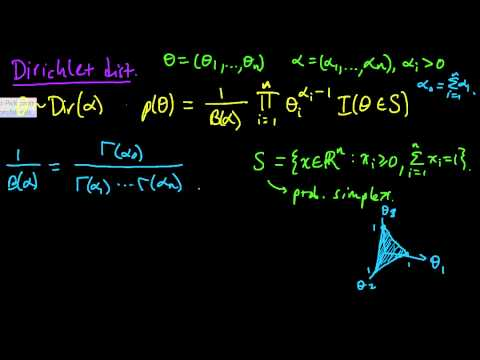

In [5]:
YouTubeVideo('nfBNOWv1pgE')

LDA is an unsupervised algorithm that assigns topics to every document. These topics are described as a set of words.  
Each document can contain several topics - more than just one topic.  
For example, some article about Apple can be 80% mobile phones and 20% about business innovations or income.

The [LDA paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) is a milestone in NLP and one of the recommended readings.

If you're interested to learn more about the algorithm method, watch this video: https://www.youtube.com/watch?v=DWJYZq_fQ2A.

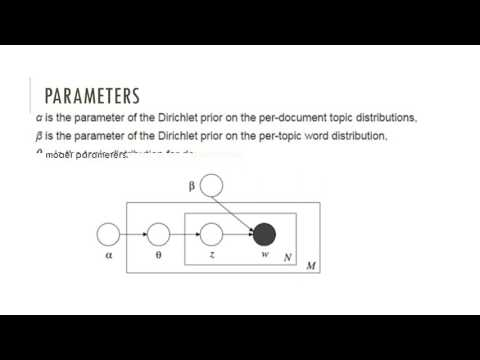

In [6]:
YouTubeVideo('DWJYZq_fQ2A')

Now, let's examine our German data set with LDA:

In previous exercises, you got to know NLTK.

### Stemming
Here we will also use NLTK's methods of **stemming** the words. By returning to the root of the word, its stem, we reduce the dimensionality: the number of words in the vocabulary decreases. For example, instead of having different words for the singular and plural form - 'word' <--> 'words' or 'Kanzler', 'Kanzlers', 'Kanzlei', etc., we trim those words into 'Kanzl'. Hence we can reduce the size of the vocabulary by at least half.

### Stop Words
We will also remove `stopwords` from our text. In English, words such as: `a`, `an`, and `the` will be removed, as they don't add much to the meaning of the sentence. For each language, there is a different curated list of such words, and NLTK is a great source for those.

### GenSim
In this exercise, you'll be introduced to another package, specialized in topic modeling, called `gensim`:
https://radimrehurek.com/gensim/



In [7]:
%pip install -U gensim --quiet

In [8]:
from pprint import pprint # for printing objects nicely

from gensim import corpora, models
from gensim.utils import simple_preprocess

## Instead of the gensim English stopwords...
# from gensim.parsing.preprocessing import STOPWORDS
## ...we use nltk's German stopwords:
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import numpy as np

from random import choice

np.random.seed(1234)

In [9]:
# Initialize the Stemmers
stemmer = SnowballStemmer('german')
german_stop_words = set(stopwords.words('german'))


def lemmatize_stemming(text):
  """lemmatize and stem a word"""
  return stemmer.stem(text)


def preprocess(text):
  """lemmatize and remove stopwords"""
  result = [lemmatize_stemming(token)
            for token in simple_preprocess(text)
            if token not in german_stop_words and len(token) > 3]
  return result


In our DataFrame, we have a table contains the articles and their topics.

We only need the articles for this tasks - we will create our own topics. So, let's start by converting the articles column into a ist of all the articles:

In [11]:
all_articles = df_articles['content'].to_list()
all_articles[:5]

['Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinn

## Preprocessing

Let's see an example, what happens when we pre-process a document.

Look at the output of this cell, and compare the tokenized original document, to the lemmatized document:

My observations: The lemmatized (preprocessed) document has fewer unique tokens/words because of the lemmatization, the removal of words of length 3 or shorter, and the removal of stopwords. Every token is in lowercase now. There also aren't any numbers in the lemmatized document anymore.

In [12]:
print('original document: ')
article = choice(all_articles)
print(article, "\n")

# This time, we don't care about punctuations as tokens (Can you think why?): #my guess: because in the preprocess function we omit all words of length 3 or shorter anyway and we lemmatise/stem so punctuation at the end of a word will also be removed.
print('original document, broken into words: ')
words = [word for word in article.split(' ')]
print(words, "\n")
print("Vocabulary size of the original article:", len(set(words)))

# now let's see what happens when we pass the article into our preprocessing
# method:
print('\n\n tokenized and lemmatized document: ')
preprocessed_article = preprocess(article)
print(preprocessed_article, '\n')
print("Vocabulary size after preprocessing:", len(set(preprocessed_article)))


original document: 
Bund schultert größeren Teil der Beamtenpensionen – Länder-Einschau in Transparenzdatenbank verlängert. Wien – Der Finanzausschuss des Nationalrats hat am Dienstagabend das Abgabenänderungsgesetz 2015 und eine Novelle zum Poststrukturgesetz auf den Weg gebracht. Ersteres enthält u.a Änderungen bei der Transparenzdatenbank, zweiteres soll einen Streit zwischen Bund und Post bzw. Telekom über die Bezahlung von Postbeamten beilegen. Den Bund kostet die Einigung 14,2 (2016) bzw. 22,2 Mio. Euro ab 2017. Das Poststrukturgesetz soll einen zwischen Bund sowie Post und Telekom schwelenden Konflikt über die Bezahlung von Postbeamten beenden, die bei der Teilprivatisierung der Unternehmen übernommen wurden. So wird der bisherige Beitrag der Firmen zur Deckung des Pensionsaufwandes ihrer Beamten ab 2017 durch einen niedrigeren Dienstgeberanteil (12,55 Prozent) ersetzt, der Dienstnehmeranteil der Beamten fließt an den Bund. Außerdem entfällt ab 2016 der bisher von Post und Telek

Now let's pre-process all the documents.  
This is a heavy procedure, and may take a bit ;)

In [13]:
processed_docs = list(map(preprocess, all_articles))
processed_docs[:10]

[['tocht',
  'degeto',
  'verpflichtet',
  'august',
  'quotenregel',
  'folg',
  'gleichstell',
  'regisseurinn',
  'sorg',
  'mindest',
  'prozent',
  'film',
  'tocht',
  'degeto',
  'produziert',
  'mitfinanziert',
  'soll',
  'mitt',
  'august',
  'frau',
  'regi',
  'fuhr',
  'degeto',
  'chefin',
  'christin',
  'strobl',
  'folgt',
  'forder',
  'quot',
  'regi',
  'verein',
  'regisseurinn',
  'vergang',
  'jahr',
  'quotenregel',
  'gefordert',
  'weiblich',
  'filmschaff',
  'mehr',
  'gehor',
  'okonom',
  'gleichstell',
  'verschaff',
  'quot',
  'regi',
  'kritisiert',
  'rund',
  'prozent',
  'regi',
  'studier',
  'weiblich',
  'seien',
  'anteil',
  'regisseurinn',
  'fernsehfilm',
  'prozent',
  'lieg',
  'osterreich',
  'sieht',
  'situation',
  'ahnlich',
  'seit',
  'handlungsbedarf',
  'angemahnt',
  'ausseh',
  'einfuhr',
  'quotenregel',
  'osterreich',
  'film',
  'sinnvoll',
  'diskuti',
  'forum'],
 ['angenomm',
  'word',
  'geplant',
  'weg',
  'gering',
  '

## Setting Up The Dictionary

Our preprocessing is complete.

We now need to calculate the occurance frequencies of each of our stemmed words. But first, we will create a vocabulary dictionary where every word appears once. Every article would be represented as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), an unordered set of words that the article contain.

---

Q: Why is it called bag-of-words?

Hint: Think about your probability lessons - where you had randomly picked out white or black balls out of a bag...

My guess: Well, the order is lost in the bag-of-words approach, so we can image it like a bag per article in which we throw all the words of that article, with their respective frequency. Then we could imagine to randomly pick a word out of the article-bag and the probability of picking that word would be its frequency divided by all the words (again, including duplicates).

In [ ]:
dictionary = corpora.Dictionary(processed_docs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's take a look:

In [ ]:
for idx, (k, v) in enumerate(dictionary.iteritems()):
    print(k, v)
    if idx >= 10:
        break


### BTW: `enumerate` is a great python function!
### It automatically creates an index, an auto-incremented counter variable,
### that represents the position of every object in the collection.

### Read more about it here: https://realpython.com/python-enumerate/

0 ahnlich
1 angemahnt
2 anteil
3 august
4 ausseh
5 chefin
6 christin
7 degeto
8 diskuti
9 einfuhr
10 fernsehfilm


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Second, we filter the tokens that may appear to often.

We have full control on the process.

### Model Hyperparameter tuning

### Your Turn:
#### Exercise 1 - Hyperparameter effect on the model output:
**Q:** How would changing these parameters influence the result?  
After running this example, please return here to change them and try them out.

In [ ]:
## Model hyper parameters:

## These are the dictionary preparation parameters:
filter_tokens_if_container_documents_are_less_than = 15
filter_tokens_if_appeared_percentage_more_than = 0.5
keep_the_first_n_tokens=100000

## and the LDA Parameters:
num_of_topics = 10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We now create a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) dictionary for each document, using [gensim's dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) tool.

It will be in the format of:

```{ 'word_id': count }```


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's take a look at the result.

Our corpus contains now only word_ids, not the words themselves, so we have to peek into the dictionary to know which word that id represents:

In [ ]:
# randomly choose an article from the corpus:
sample_bow_doc = choice(bow_corpus)

print('The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:')
print(sample_bow_doc, '\n\n')

print ('We peek in the dictionary: for each word_id, we get its assigned word:')
for word_id, word_freq in sample_bow_doc:
  real_word = dictionary[word_id]
  print(f'Word #{word_id} ("{real_word}") appears {word_freq} time.')


The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:
[(14, 1), (30, 1), (31, 1), (32, 1), (35, 1), (40, 1), (48, 1), (52, 1), (79, 3), (102, 1), (104, 2), (106, 1), (110, 1), (117, 2), (123, 1), (144, 1), (193, 1), (211, 1), (218, 1), (219, 1), (245, 1), (258, 1), (271, 1), (315, 1), (325, 1), (333, 1), (343, 1), (366, 2), (372, 1), (392, 1), (400, 1), (413, 1), (423, 1), (441, 2), (442, 2), (451, 1), (558, 1), (571, 1), (589, 1), (606, 1), (619, 2), (631, 1), (635, 1), (638, 1), (639, 1), (647, 3), (665, 1), (683, 1), (696, 1), (719, 1), (751, 6), (762, 1), (788, 2), (813, 2), (833, 1), (869, 1), (918, 2), (961, 1), (969, 1), (977, 1), (996, 1), (1013, 2), (1019, 1), (1062, 1), (1063, 1), (1067, 3), (1083, 1), (1126, 1), (1134, 1), (1168, 1), (1348, 1), (1420, 1), (1454, 1), (1505, 1), (1509, 1), (1571, 1), (1666, 1), (1674, 1), (1677, 1), (1689, 1), (1701, 1), (1734, 1), (1776, 1), (1826, 2), (1884, 1), (2025, 1), (2032, 1), (2097, 1), (2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA model using Bag-of-words

Let's start by applying the LDA model using the bag-of-words (Warning: this could take a while):

In [ ]:
lda_model = models.LdaMulticore(bow_corpus,
                                num_topics=num_of_topics,
                                id2word=dictionary,
                                passes=5,
                                workers=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It is done!

Now we can observe which topics the model had extracted from the documents.

- *Topics* are made of sets of words and their distribution for that topic, representing their weight in that topic.
- Every document may be composed of multiple topics, with different weights representing the relation to each topics.

We will loop over the extracted topics and examine the words that construct them.

In [ ]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')


Topic: 0 	 Words: 0.008*"polit" + 0.008*"sagt" + 0.007*"standard" + 0.006*"wien" + 0.005*"grun" + 0.005*"partei" + 0.005*"land" + 0.005*"regier" + 0.004*"wahl" + 0.004*"seit"
Topic: 1 	 Words: 0.032*"prozent" + 0.016*"osterreich" + 0.014*"jahr" + 0.007*"euro" + 0.007*"standard" + 0.006*"wenig" + 0.006*"land" + 0.006*"hoh" + 0.005*"zahl" + 0.005*"wien"
Topic: 2 	 Words: 0.020*"euro" + 0.013*"wien" + 0.010*"million" + 0.009*"jahr" + 0.007*"prozent" + 0.006*"unternehm" + 0.006*"neu" + 0.006*"osterreich" + 0.006*"rund" + 0.005*"seit"
Topic: 3 	 Words: 0.009*"jahr" + 0.006*"wien" + 0.006*"erst" + 0.006*"gross" + 0.005*"schon" + 0.004*"sagt" + 0.004*"lang" + 0.004*"imm" + 0.004*"ganz" + 0.004*"forsch"
Topic: 4 	 Words: 0.010*"spiel" + 0.009*"erst" + 0.006*"forsch" + 0.005*"salzburg" + 0.004*"wien" + 0.004*"zwei" + 0.004*"jahr" + 0.004*"rapid" + 0.004*"schon" + 0.004*"konnt"
Topic: 5 	 Words: 0.010*"neu" + 0.006*"sagt" + 0.006*"griechenland" + 0.005*"nutz" + 0.005*"appl" + 0.004*"soll" + 0.00

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## TF / IDF

Let's take it one step further. We will cluster our document by running the LDA using [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

We start with TF/IDF calculation on our bag-of-words.
TF/IDF accepts a dictionary of word frequencies as an input, and it calculates the term frequency and the inversed document frequency accordingly.

Its output is a re-weighted dictionary of the documents term frequencies:

In [ ]:
# initialize a tfidf from our corpus
tfidf = models.TfidfModel(bow_corpus)

# apply it on our corpus
tfidf_corpus = tfidf[bow_corpus]

pprint(tfidf_corpus[0][:10])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.07624324224596976),
 (1, 0.09765147703315807),
 (2, 0.17806134714371552),
 (3, 0.12554321379384176),
 (4, 0.12114843374003081),
 (5, 0.14917128474504127),
 (6, 0.11948454964321391),
 (7, 0.10815383759404282),
 (8, 0.19221567840914694),
 (9, 0.0625612949812136)]


In [ ]:
# the new tfidf corpus is just our corpus - but transformed. It has the same size of documents:
assert len(bow_corpus) == len(tfidf_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now let's apply LDA on the tfidf corpus, with the same amount of topics.

You can play with the # of passes, if the model doesn't converge properly

In [ ]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus,
                                      num_topics=num_of_topics,
                                      id2word=dictionary,
                                      passes=5,
                                      workers=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.005*"prozent" + 0.004*"zielpunkt" + 0.003*"euro" + 0.003*"unternehm" + 0.002*"million" + 0.002*"pfeiff" + 0.002*"dollar" + 0.002*"forsch" + 0.002*"bank" + 0.002*"wien"
Topic: 1 	 Word: 0.003*"euro" + 0.002*"prozent" + 0.002*"europa" + 0.002*"million" + 0.002*"kommission" + 0.002*"osterreich" + 0.002*"jahr" + 0.002*"milliard" + 0.002*"konz" + 0.002*"unternehm"
Topic: 2 	 Word: 0.003*"fluchtling" + 0.003*"griechenland" + 0.002*"griechisch" + 0.002*"word" + 0.002*"regier" + 0.002*"ath" + 0.002*"sagt" + 0.002*"mensch" + 0.002*"land" + 0.002*"euro"
Topic: 3 	 Word: 0.015*"volltext" + 0.014*"basier" + 0.012*"artikel" + 0.011*"rechtlich" + 0.009*"verfug" + 0.008*"grund" + 0.007*"steht" + 0.003*"prozent" + 0.003*"euro" + 0.002*"forsch"
Topic: 4 	 Word: 0.004*"prozent" + 0.003*"euro" + 0.002*"milliard" + 0.002*"osterreich" + 0.002*"million" + 0.002*"unternehm" + 0.002*"wien" + 0.001*"jahr" + 0.001*"neu" + 0.001*"rapid"
Topic: 5 	 Word: 0.004*"prozent" + 0.003*"euro" + 0.002*"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Inference

Now that we have a topic-modeler, let's use it on one of the articles.

In [ ]:
# randomly pick an article:
test_doc = choice(range(len(processed_docs)))
processed_docs[test_doc][:50]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['toronto',
 'gewinnt',
 'philadelphia',
 'michael',
 'raffl',
 'chicago',
 'stellt',
 'sieg',
 'folg',
 'neu',
 'clubrekord',
 'philadelphia',
 'michael',
 'grabn',
 'dienstag',
 'freund',
 'michael',
 'raffl',
 'duell',
 'beid',
 'villach',
 'eishockey',
 'sturm',
 'national',
 'hockey',
 'leagu',
 'gewonn',
 'grabn',
 'gewann',
 'toronto',
 'mapl',
 'leaf',
 'philadelphia',
 'flyer',
 'matt',
 'hundwick',
 'erzielt',
 'sekund',
 'schlusssir',
 'entscheid',
 'treff',
 'gast',
 'toronto',
 'zuletzt',
 'funf',
 'niederlag',
 'kassiert',
 'flyer',
 'blieb',
 'erstmal']

Using the original BOW model:

In [ ]:
for index, score in sorted(lda_model[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print(f"Topic match score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")


Topic match score: 0.9902136325836182 
Topic: 0.006*"erst" + 0.006*"spiel" + 0.005*"seit" + 0.005*"israel" + 0.005*"sagt" + 0.005*"jahr" + 0.004*"minut" + 0.004*"zwei" + 0.004*"beim" + 0.004*"leagu"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And with the TF/IDF model:

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print("Topic match score: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))

Topic match score: 0.5551183223724365	 
Topic: 0.003*"euro" + 0.002*"prozent" + 0.002*"europa" + 0.002*"million" + 0.002*"kommission" + 0.002*"osterreich" + 0.002*"jahr" + 0.002*"milliard" + 0.002*"konz" + 0.002*"unternehm"
Topic match score: 0.43617144227027893	 
Topic: 0.002*"prozent" + 0.002*"wien" + 0.002*"standard" + 0.002*"osterreich" + 0.001*"spiel" + 0.001*"euro" + 0.001*"jahr" + 0.001*"neu" + 0.001*"erst" + 0.001*"gross"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculating the [perplexity score](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94) (lower is better):

In [ ]:
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))
print('Perplexity TFIDF: ', lda_model_tfidf.log_perplexity(bow_corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -7.997607384640231
Perplexity TFIDF:  -8.47706411507947


### Exercise - inference

Now please try it on a new document!

Go to a news website, such as [orf.at](https://orf.at/) and copy an article of your choice here:

In [ ]:
unseen_document = """Sobotka sprach in einer um eineinhalb Stunden verspäteten Pressekonferenz am Abend von einer „schwierigen“, aber „sachlichen und pointierten“ Diskussion im Hauptausschuss. Er meinte, dass von Gesundheitsminister Rudolf Anschober (Grüne), die „Notwendigkeit, Verhältnismäßigkeit und Richtigkeit“ der Maßnahmen erläutert worden seien. Zudem betonte Sobotka die Wichtigkeit der im Covid-Maßnahmengesetz vorgesehenen Mitsprache des Parlaments bei Maßnahmen, bei denen auch die Freiheitsrechte betroffen seien.
Der Nationalratspräsident zitierte auch die deutsche Kanzlerin Angela Merkel, die die Maßnahmen im Kampf gegen die Pandemie als „demokratische Zumutung“ bezeichnet hatte. Dem sei nicht nur zuzustimmen, das sei auch zu unterstreichen, sagte er. Die Eindämmung der Pandemie könne aber nur gelingen, wenn sich alle Österreicher einbringen. Der Beschluss alleine reiche nicht, die Maßnahmen müssten auch im Geiste verinnerlicht werden, appellierte Sobotka an die Bevölkerung, die Maßnahmen mitzutragen.
Rendi-Wagner kritisiert Regierung
Die Opposition hatte schon vor der Sitzung – und dann auch noch einmal danach – ihre Kritik an der Regierung bekräftigt. „Die Bundesregierung hat die Kontrolle über das Infektionsgeschehen verloren und hat die schwierige Situation, vor der wir jetzt stehen, zu verantworten“, kritisierte SPÖ-Klub- und Parteivorsitzende Rendi-Wagner.
Sessel auf Tischen in einem geschlossenen Lokal
DEBATTEWie gerechtfertigt sind die Maßnahmen?"""

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("Simply printing the lda_model output would look like this:")
pprint(lda_model[bow_vector])

print("\n\nSo let's make it nicer, by printing the topic contents:")
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Simply printing the lda_model output would look like this:
[(0, 0.9890117)]


So let's make it nicer, by printing the topic contents:
Score: 0.9890117049217224	 Topic: 0.008*"polit" + 0.008*"sagt" + 0.007*"standard" + 0.006*"wien" + 0.005*"grun"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualization

Finally, there are packages that can visulaize the results, such as [pyLDAvis](https://pypi.org/project/pyLDAvis/) and [tmplot](https://pypi.org/project/tmplot/).

Let's take a look at pyLDAvis visualization result.

**Please note:** this is an old and unmaintained package. It is easier to run it in Google-Colab than on your laptop. But, if you still try running it locally, please try **lowering your python version** (3.6 / 3.6 / 3.8) when you create the poetry environment for this exercise.

In [ ]:
%pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

bow_lda_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

pyLDAvis.display(bow_lda_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Your turn - Do it yourself:

Replace the given corpus with one in another language - maybe your own native language? You can find corpus online, for example:
- https://www.corpusdata.org/intro.asp
- or here: https://www.clarin.eu/resource-families/newspaper-corpora
- or even in nltk: https://www.nltk.org/nltk_data/
- In this github, there are many datasets that can be loaded through their `raw` url: https://github.com/selva86/datasets

Careful: You will need to change the [Stemming](https://snowballstem.org/algorithms/) and the [Stopwords](https://www.kaggle.com/rtatman/stopword-lists-for-19-languages) to support your language. Make a web-search after the appropriate ones (if they exist..)

Use the notebook to reproduce the result.  
Try changing the parameters to get a *satisfying level of clustering*.  
Which parameters worked best for the language you chose?

##### Help note

If your corpus is a csv, [pandas' read_csv method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) would be the best way to tackle it.

If it is, however a text file or a zip of text files, you will need another way to load them. Luckily, python is working well with both - text and zip files, with a built-in support.

###### Example with text
For the sake of this example, let's download two files: one text file, and one gzip file, from this website:

https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-6260-A

In [ ]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A{/README.txt,/hindmonocorp05.plaintext.gz}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4472  100  4472    0     0   3258      0  0:00:01  0:00:01 --:--:--  3259
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2353M  100 2353M    0     0  19.3M      0  0:02:01  0:02:01 --:--:-- 20.0M


Files are accessed using the `Path` package of python's pathlib:

In [ ]:
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To access a file, we use its path in Path, like so:

`Path('Folder/filename.extension')`

Path has many methods for files and folder. Including looping over files in folder, checking if a file exists, etc.

Read more about it here: https://docs.python.org/3/library/pathlib.html

In [ ]:
readme_file = Path('README.txt')

if readme_file.exists():
  # read the text content into a variable
  file_content = readme_file.read_text()
  print(file_content)
else:
  print("README.txt was not found...")

HindEnCorp 0.5 and HindMonoCorp 0.5 File Formats

This file describes the file formats of the Hindi-English and Hindi-only
corpora released in 2014 under the names HindEnCorp 0.5 and HindMonoCorp 0.5.

More details about the preparation of the corpora can be found in the paper:

  Ondřej Bojar, Vojtěch Diatka, Pavel Rychlý, Pavel Straňák, Aleš Tamchyna
  and Dan Zeman. HindEnCorp - Hindi-English and Hindi-only Corpus for
  Machine Translation. In Proc. of LREC 2014. Reykjavik, Iceland. ISBN
  978-2-9517408-8-4. ELRA. 2014.

or on the corpora web page:
  http://ufal.mff.cuni.cz/hindencorp

Please cite this paper if you make any use of the corpora. BibTeX citation
format below.


Common Properties
-----------------

All the files are plain text:

- compressed with gzip
- encoded in UTF-8
- with unix line breaks (LF)
- with tab-delimited columns

The monolingual and parallel corpora have different columns.

The actual corpus text is stored in one (monolingual corpus) or two (parallel
corp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If the file is a `.zip` file, you can open it and read its data without actually extracting all the files from it.

https://docs.python.org/3/library/gzip.html

Also, [requests](https://requests.readthedocs.io/en/latest/) is a great package of retrieving content from a URL.

###### Example with zipped files

In [ ]:
import gzip


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# this would download the file (but it's 2 GB, so go easy on your internet provider...):
# file = requests.get('https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A/hindmonocorp05.plaintext.gz')
# with gzip.open(file.content, 'rb') as gz:
#  ...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this example, we will open the zip and read the text lines.
The text is in hindi, so we have to decode it into `UTF-8` format:

In [ ]:
with gzip.open('hindmonocorp05.plaintext.gz', 'rb') as gz:
  for i in range(10):
    line = gz.readline()
    words = line.decode('utf8').split()
    print(words)


['hwt2013', '<s>', 'लेकिन', 'गांव', 'के', 'जगदीश', 'मेघवाल,', 'मोहन...']
['spiderling', '<s>', 'विटामिन', 'सी', 'शरीर', 'में', 'रोग', 'पैदा', 'करने', 'वाले', 'विषाणुओं', 'से', 'लड़ने', 'की', 'ताकत', 'पैदा', 'करता', 'है', 'और', 'शरीर', 'में', 'इसकी', 'संतुलित', 'मात्रा', 'बने', 'रहने', 'से', 'रोग', 'प्रतिरोधक', 'क्षमता', 'मजबूत', 'रहती', 'है।']
['spiderling', '<s>', 'इन', 'बोतलों', 'के', 'बहुत', 'कम', 'पैसे', 'मिलते', 'हैं।']
['commoncrawl', '<a>', 'कार्टून', ':-', 'रे', 'लोकपाल', 'आ', 'गया', 'तू', '?', 'शाबाश....', '19', '0']
['spiderling', '<s>', 'प्रखर', 'बुद्धि', 'तेजस्वी', 'बालक', 'राजेन्द्र', 'बाल्यावस्था', 'में', 'ही', 'फारसी', 'में', 'शिक्षा', 'ग्रहण', 'करने', 'लगा', 'और', 'उसके', 'पश्चात', 'प्राथमिक', 'शिक्षा', 'के', 'लिए', 'छपरा', 'के', 'जिला', 'स्कूल', 'में', 'नामांकित', 'हो', 'गया।']
['commoncrawl', '<a>', 'निदेशक', 'स्तर', 'का', 'एक', 'वैज्ञानिक', 'संस्थान', 'या', 'सहोदर', 'संस्थान', 'से', '(']
['commoncrawl', '<a>', 'गज़ब', 'का', 'बतंगड़', 'है!', ':)', 'हिट', 'तो', 'वैसे',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**IMPORTANT NOTE**: If your corpus, like that file example is very large (2.3GB zipped), then please don't load all the text: it will not fit in the memory and will only cause you trouble.  
Instead, you can use only the first 10 to 20k sentences, or so. For this exercise we just want you to get a hold of the steps and the proces involved in using LDA.

# Afterword

Gensim is not the only library that implements the LDA algorithm.
Another package that does LDA is [tomotopy](https://bab2min.github.io/tomotopy/v0.12.3/en/) - sometimes even faster than gensim. Additionaly, it is implemented as part of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) - which we use often in the course.

Here's a jupyter example using Scikit-learn and spaCy: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

Since we won't dive deeper into the LDA topic in this course, if you wish to know more about the statistics behind it, [this video](https://www.youtube.com/watch?v=0jQo8lVRHRY) of a lesson by the researcher [Nando de Freitas](https://linkedin.com/in/nandodefreitas) gives a good overview.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
